# Geometrical Methods in Machine Learning

## Homework 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits

### Task 1: Intrinsic dimension estimation (4 points)

Implement $2$ intrinsic dimension estimation methods from an individual list for your triple (see the assignment). Specify the methods you have chosen in the canvas Homework 2 comments.

Each method should be realized as a Python class implementing public method `fit` as well as providing access to public class variable(s) `dimension` (all methods), `local_dimension`, `dimension_multiscale`, `local_dimension_multiscale` (specific methods).

- `fit` method should return the estimate $\hat{d}$ of the intrinsic dimensionality of the data as well as setting the scalar `dimension` property of the class,
- if the method is _local_, the vector of dimension $n$ `local_dimension` property should be present with `dimension` being their median or mean aggregates along points,
- if the method is _multiscale_, the vector of dimenson $s$ `dimension_multiscale` and the matrix of dimensions $s \times n$ `local_dimension_multiscale` should be present as well, with `dimension` and `local_dimension` being their median or mean aggregates along scales.

Be sure to give a method summary, describing its (see the examples below)
- idea,
- the estimator formula and/or algorithm,
- the reference to pages with estimator derivation, and
- the list of reference(s).

**Grading:** Implementing any single method is awarded with $3$ points, implementing both with $4$ points.

### Examples

In [2]:
# load data
X, y = load_digits(return_X_y=True)

#### MLE

**Idea**

Local intrinsic dimension estimator based on the principle of maximum likelihood to the distances between close neighbors.

**Estimator formula/algorithm**

Let we use $k$ nearest neighbors $\mathbf{x}_1, \dots, \mathbf{k}_n$ of a point $\mathbf{x}$ and $r_j = d(\mathbf{x}, \mathbf{x}_j)$ is the distance from a point $\mathbf{x}$ to the $k$-th nearest neighbor, then the local MLE estimate of the intrinsic dimension is [Levina2005, Eq. 8]

$$\hat{d}_k(\mathbf{x}) = \left[ \frac{1}{k - 1} \sum_{j=1}^{k - 1} \log \frac{r_k(\mathbf{x})}{r_j(\mathbf{x})} \right]^{-1}$$

Averaging over $\hat{d}_k(\mathbf{x})$ gives the intrinsic dimension of the dataset $\mathbf{X}$.

**Estimator derivation**

For derivation see [Levina2005, pp. 3-4].

**References**  
- [Levina2005] Levina, E., Bickel, P. Maximum Likelihood Estimation of Intrinsic Dimension. _Advances in Neural Information Processing Systems (2005)_

In [3]:
from sklearn.neighbors import NearestNeighbors

class MLE():

    def __init__(self, k=5, aggregate="mean", eps=1e-6):

        super().__init__()

        self.k = k
        self.eps = eps

        if aggregate=="mean":
            self.aggregate = np.mean
        elif aggregate=="median":
            self.aggregate = np.median
        else:
            raise ValueError("Aggregate function should be 'mean' or 'median'")

    def fit(self, X):

        # get distances within up to the k-th nearest neighor for each point
        nn = NearestNeighbors(n_neighbors=self.k).fit(X)
        distances, _ = nn.kneighbors()
        distances += self.eps # fix duplicate points, causing d(x_i, x_j)=0

        # get local and global intrinsic dimensions
        log_distance_ratios = np.log(distances[:,self.k-1:self.k] / distances[:,:self.k-1])
        self.local_dimension = ((self.k - 2) ** -1 * np.sum(log_distance_ratios, axis=1)) ** -1
        self.dimension = self.aggregate(self.local_dimension)

        return self.dimension

In [4]:
# create estimator
estimator = MLE()

# fit estimator, returns (global) intrinsic dimension
dimension = estimator.fit(X)

# get estimates of global and local intrinsic dimensions
dimension = estimator.dimension
local_dimension = estimator.local_dimension

dimension, local_dimension.shape

(8.339146894870613, (1797,))

#### PCA-based

**Idea**

Global dimension estimator corresponding to specified level of explained variance given by the singular value decomposition of the centered data matrix.

**References**  
- [Pearson1901] Pearson, K. On Lines and Planes of Closest Fit to Systems of Points in Space. _Philosophical Magazine (1901)_

In [5]:
from sklearn.decomposition import PCA

class PCAd():

    def __init__(self, explained_variance=0.95):
        super().__init__()
        self.explained_variance = explained_variance

    def fit(self, X):
        pca = PCA(n_components=self.explained_variance)
        pca.fit(X)
        self.dimension = pca.n_components_

        return self.dimension

In [6]:
# create estimator
estimator = PCAd()

# fit estimator, returns (global) intrinsic dimension
dimension = estimator.fit(X)

# get estimate of (global) dimension
dimension = estimator.dimension
dimension

29

#### Method of Moments

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

class MoM:
    def __init__(self, scales=None, k=5, aggregate="mean", eps=1e-6):
        self.scales = scales
        self.k = k
        self.eps = eps
        if aggregate == "mean":
            self.aggregate = np.mean
        elif aggregate == "median":
            self.aggregate = np.median
        else:
            raise ValueError("Aggregate function should be 'mean' or 'median'")

        self.dimension = None
        self.local_dimension = None
        self.dimension_multiscale = None
        self.local_dimension_multiscale = None

    def fit(self, X):
        if self.scales is None:
            # local method
            nn = NearestNeighbors(n_neighbors=self.k).fit(X)
            distances, _ = nn.kneighbors(X)
            distances += self.eps

            mean_d = np.mean(distances, axis=1)
            var_d = np.var(distances, axis=1)
            self.local_dimension = mean_d / var_d
            self.dimension = self.aggregate(self.local_dimension)
            return self.dimension
        else:
            # multiscale method
            local_dims = []
            global_dims = []
            for scale in self.scales:
                nn = NearestNeighbors(n_neighbors=scale).fit(X)
                distances, _ = nn.kneighbors(X)
                distances += self.eps

                mean_d = np.mean(distances, axis=1)
                var_d = np.var(distances, axis=1)
                local_dim = mean_d / var_d
                global_dim = self.aggregate(local_dim)

                local_dims.append(local_dim)
                global_dims.append(global_dim)

            self.local_dimension_multiscale = np.array(local_dims)
            self.dimension_multiscale = np.array(global_dims)
            self.local_dimension = self.aggregate(self.local_dimension_multiscale, axis=0)
            self.dimension = self.aggregate(self.dimension_multiscale)
            return self.dimension


mom_single = MoM(k=5, aggregate="mean")
mom_single_dimension = mom_single.fit(X)
print(f"MoM Single-scale Estimated Dimension: {mom_single_dimension}")

#multiscale method
scales = [3, 5, 7]
mom_multiscale = MoM(scales=scales, aggregate="mean")
mom_multiscale_dimension = mom_multiscale.fit(X)
print(f"MoM Multiscale Estimated Dimension: {mom_multiscale_dimension}")


MoM Single-scale Estimated Dimension: 0.26794850192907826
MoM Multiscale Estimated Dimension: 0.264503275720496


####Geodesic Minimal Spanning Tree

In [9]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

class GMSTIntrinsicDimension:
    def __init__(self):
        self.dimension = None
        self.local_dimension = None
        self.dimension_multiscale = None
        self.local_dimension_multiscale = None

    def fit(self, X):
        self._compute_gmst(X)
        return self.dimension

    def _compute_gmst(self, X):
        # Compute the pairwise distance matrix
        dist_matrix = distance_matrix(X, X)

        # Construct the minimum spanning tree
        mst = minimum_spanning_tree(dist_matrix)

        # Extract the lengths of the edges in the MST
        edge_lengths = mst.data

        # Estimate the intrinsic dimension
        estimated_id = self._estimate_dimension_from_edges(edge_lengths)


        self.dimension = estimated_id
        self.local_dimension = np.repeat(estimated_id, X.shape[0])
        self.dimension_multiscale = np.array([estimated_id])
        self.local_dimension_multiscale = np.tile(self.local_dimension, (1, 1))

    def _estimate_dimension_from_edges(self, edge_lengths):
        """
        Estimate the intrinsic dimension from MST edge lengths.

        Parameters:
        edge_lengths (array-like): Lengths of the edges in the MST

        Returns:
        float: Estimated intrinsic dimension
        """
        log_edge_lengths = np.log(edge_lengths)
        estimated_id = np.mean(log_edge_lengths)

        return estimated_id

gmst_estimator = GMSTIntrinsicDimension()
estimated_id = gmst_estimator.fit(X)
print(f"Estimated Intrinsic Dimension: {estimated_id}")
print(f"Local Dimension: {gmst_estimator.local_dimension}")
print(f"Dimension Multiscale: {gmst_estimator.dimension_multiscale}")
print(f"Local Dimension Multiscale: {gmst_estimator.local_dimension_multiscale}")


Estimated Intrinsic Dimension: 2.8166002530730294
Local Dimension: [2.81660025 2.81660025 2.81660025 ... 2.81660025 2.81660025 2.81660025]
Dimension Multiscale: [2.81660025]
Local Dimension Multiscale: [[2.81660025 2.81660025 2.81660025 ... 2.81660025 2.81660025 2.81660025]]


### Task 2: Manifold learning (4 points)

Obtain `Extended Yale B` face dataset ([download](https://github.com/oleg-kachan/GMML2023/blob/main/hw2/data/CroppedYale.zip)) which is comprised of $100 \times 100$ pixels images of $38$ persons times $64$ illumination conditions. Resize images to $32 \times 32$ pixels. You can do it using `Pillow` ([link](https://pillow.readthedocs.io/), tested) or any other image processing library of your choice.

1. Estimate the intrinsic dimensionality with a method(s) of your choice (methods from task 1 are perfect candidates) and perform dimensionality reduction to the intrinsic dimension $\hat{d}$ and dimensions $2$ or $3$ for visualization purposes using manifold learning methods of your choice.

2. Compute NPR (neigborhood preservation ratio, see [seminar 4](https://github.com/oleg-kachan/GMML2022/blob/main/seminar4/seminar4_solution.ipynb)) of algorithms you have used for 2 different values of $d = \{2$ or $3, \hat{d} \}$ and fixed number of nearest neighbors $k$.

3. Explore the embedding space of dimension $2$ or $3$ for clusters and meaningful interpretations, comment the possible meaning of the new coordinates.

4. Compute and plot persistence diagrams for dimensions $0$ and $1$, conclude whether the dataset have untrivial topology such a several clusters and/or presence of cycles in dimension $1$. If applicable, how can one explain a presence of cycles for the `Extended Yale B` face dataset?

**Grading:** Each subtask is awarded with $1$ point.

In [ ]:
!pip install ripser

In [ ]:
!pip install persim

In [30]:
import os
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from ripser import ripser
from persim import plot_diagrams
from sklearn.neighbors import NearestNeighbors

In [20]:
#Downloading Dataset

url = 'https://github.com/oleg-kachan/GMML2023/raw/main/hw2/data/CroppedYale.zip'

path = '/content/CroppedYale.zip'

# Download the file
response = requests.get(url)
with open(path, 'wb') as file:
    file.write(response.content)

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content')

def load_images(data_dir, target_size=(32, 32)):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.pgm'):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).resize(target_size)
                images.append(np.array(img).flatten())
                labels.append(root.split('/')[-1])
    return np.array(images), labels

data_dir = '/content/CroppedYale'
data, labels = load_images(data_dir)
data = data / 255.0

#### 1.

In [22]:
from sklearn.neighbors import NearestNeighbors

class MoM:
    def __init__(self, scales=None, k=5, aggregate="mean", eps=1e-6):
        self.scales = scales
        self.k = k
        self.eps = eps
        if aggregate == "mean":
            self.aggregate = np.mean
        elif aggregate == "median":
            self.aggregate = np.median
        else:
            raise ValueError("Aggregate function should be 'mean' or 'median'")

        self.dimension = None
        self.local_dimension = None
        self.dimension_multiscale = None
        self.local_dimension_multiscale = None

    def fit(self, X):
        if self.scales is None:
            # Single-scale (local) method
            nn = NearestNeighbors(n_neighbors=self.k).fit(X)
            distances, _ = nn.kneighbors(X)
            distances += self.eps  # fix duplicate points, causing d(x_i, x_j)=0

            mean_d = np.mean(distances, axis=1)
            var_d = np.var(distances, axis=1)
            self.local_dimension = mean_d / var_d
            self.dimension = self.aggregate(self.local_dimension)
            return self.dimension
        else:
            # Multiscale method
            local_dims = []
            global_dims = []
            for scale in self.scales:
                nn = NearestNeighbors(n_neighbors=scale).fit(X)
                distances, _ = nn.kneighbors(X)
                distances += self.eps  # fix duplicate points, causing d(x_i, x_j)=0

                mean_d = np.mean(distances, axis=1)
                var_d = np.var(distances, axis=1)
                local_dim = mean_d / var_d
                global_dim = self.aggregate(local_dim)

                local_dims.append(local_dim)
                global_dims.append(global_dim)

            self.local_dimension_multiscale = np.array(local_dims)
            self.dimension_multiscale = np.array(global_dims)
            self.local_dimension = self.aggregate(self.local_dimension_multiscale, axis=0)
            self.dimension = self.aggregate(self.dimension_multiscale)
            return self.dimension

In [23]:
mom_single = MoM(k=5, aggregate="mean")
mom_single_dimension = mom_single.fit(data)
print(f"MoM Single-scale Estimated Dimension: {mom_single_dimension}")

MoM Single-scale Estimated Dimension: 1.2053724806436517


In [38]:
def reduce_and_plot(method, data, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Plot for d = mom_single_dimension
    reduced_data_mom = method(n_components=int(mom_single_dimension)).fit_transform(data)
    scatter = ax.scatter(reduced_data_mom[:, 0], np.zeros_like(reduced_data_mom[:, 0]), c=[int(label.split('yaleB')[1]) for label in labels], cmap='viridis', s=5)
    ax.set_xlabel('Component 1')
    ax.set_title(f'{method.__name__} with d={int(mom_single_dimension)}')
    plt.colorbar(scatter, ax=ax, label='Classes')
    plt.tight_layout()
    plt.show()

    # Plot for d = 2
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    reduced_data_2d = method(n_components=2).fit_transform(data)
    ax.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=[int(label.split('yaleB')[1]) for label in labels], cmap='viridis', s=5)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f'{method.__name__} with d=2')
    plt.colorbar(scatter, ax=ax, label='Classes')
    plt.tight_layout()
    plt.show()

    # Plot for d = 3
    reduced_data = method(n_components=3).fit_transform(data)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=[int(label.split('yaleB')[1]) for label in labels], cmap='viridis', s=5)
    plt.colorbar(sc)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.title(f'{method.__name__} with d=3')
    plt.colorbar(scatter, ax=ax, label='Classes')
    plt.tight_layout()
    plt.show()

In [36]:
plt.rcParams['text.usetex'] = False

Seems like the two components capture the most significant variations in the data: noticable clusters suggest that t-SNE effectively captures the manifold of the data in 2D, making it easier to identify groupings based on facial features and lighting variations.
As for 3D embedding, clusters seems a bit noticable then in 2d, and next we will see that the NBR values are really quite close.

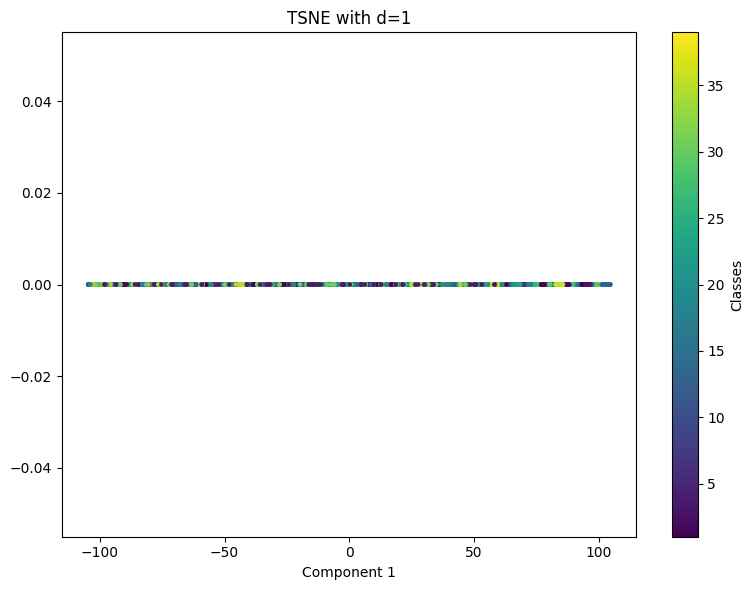

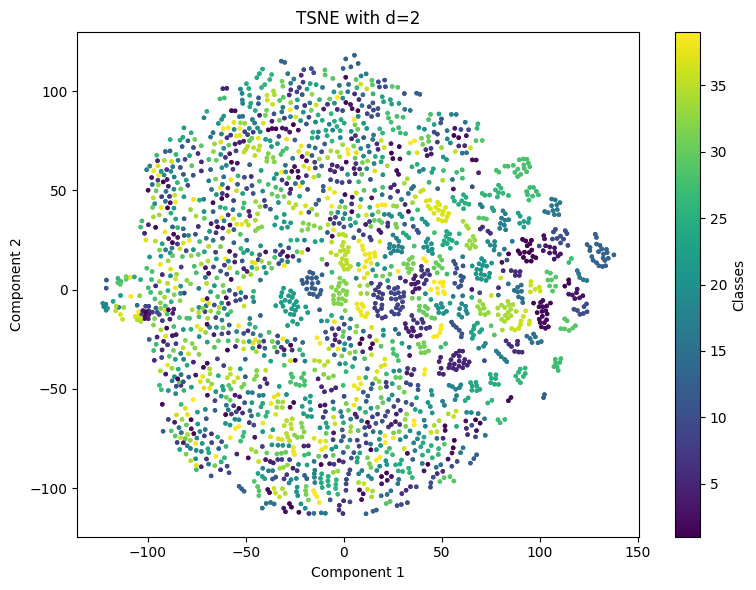

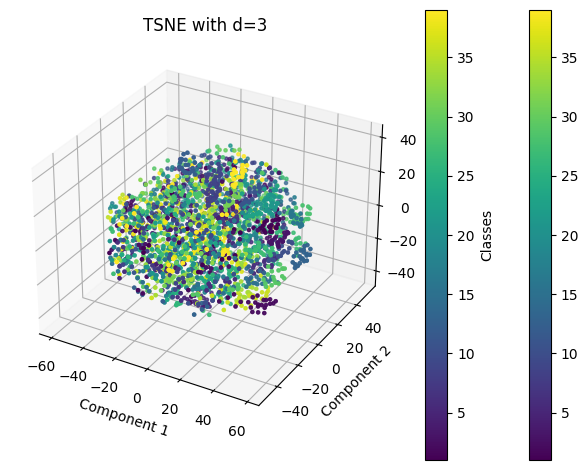

In [39]:
reduce_and_plot(TSNE, data, labels)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages

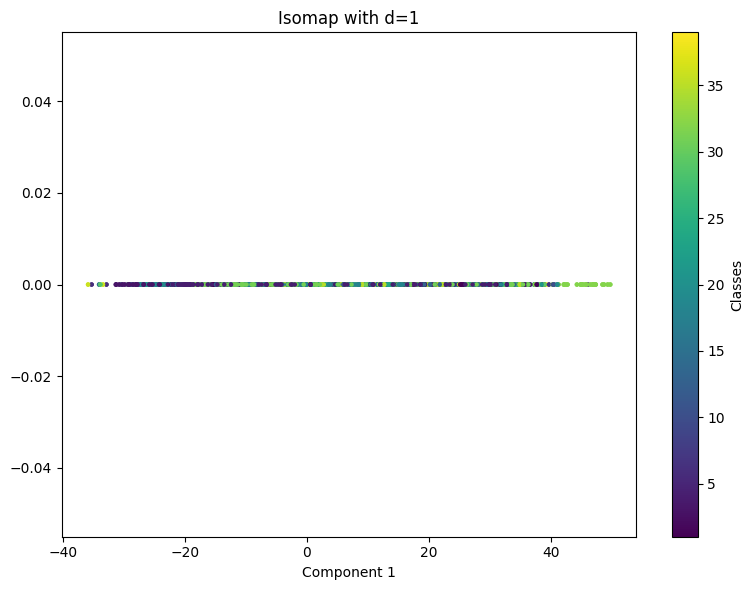

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages

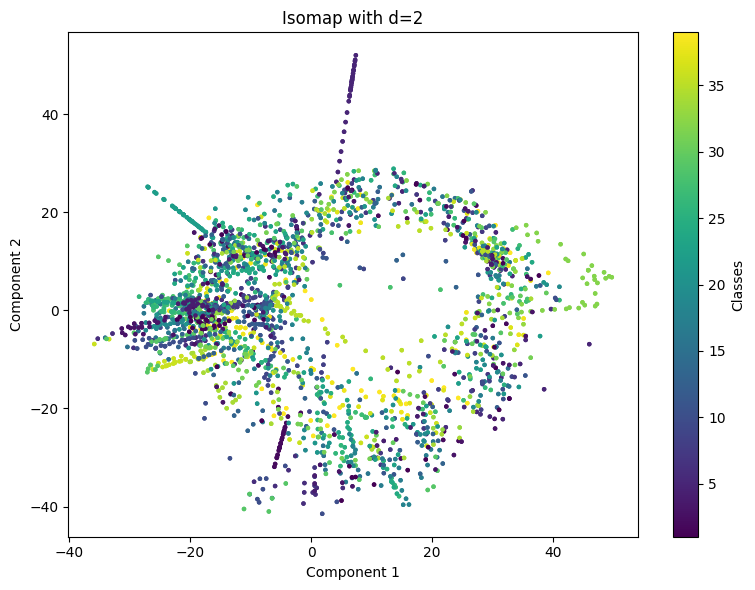

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages

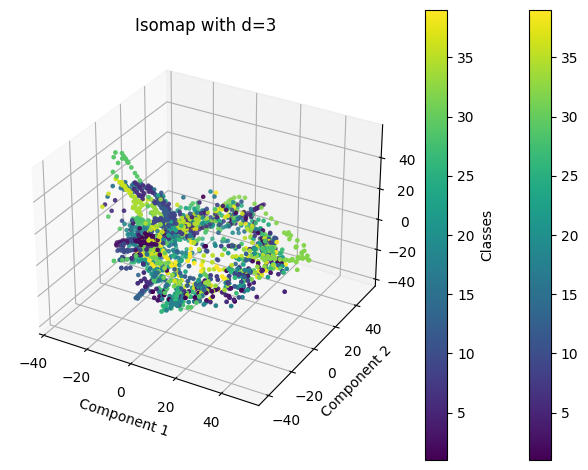

In [40]:
reduce_and_plot(Isomap, data, labels)

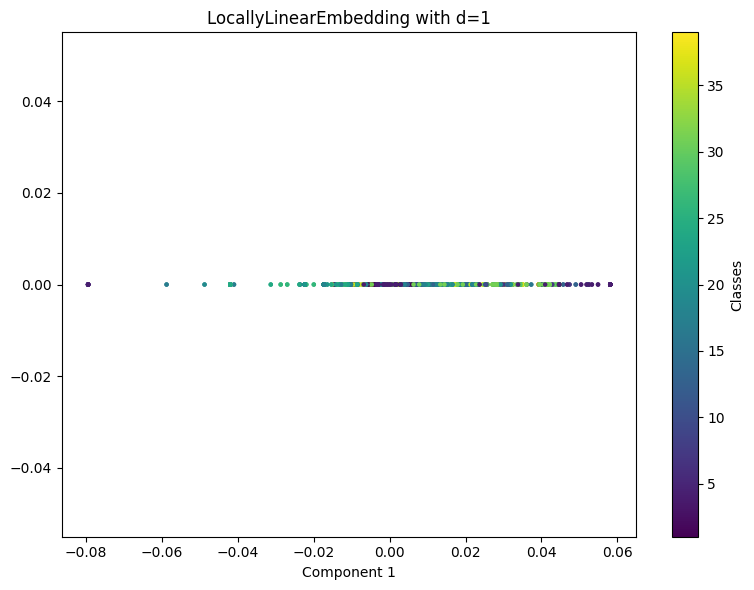

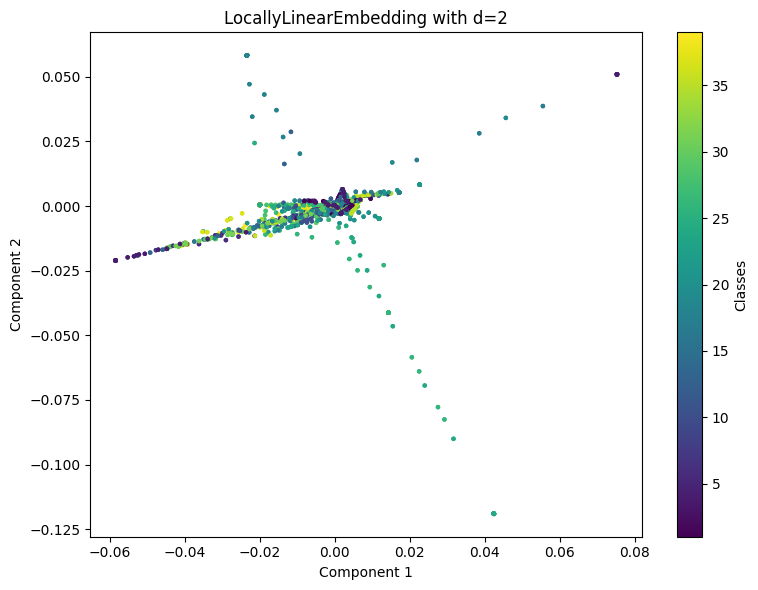

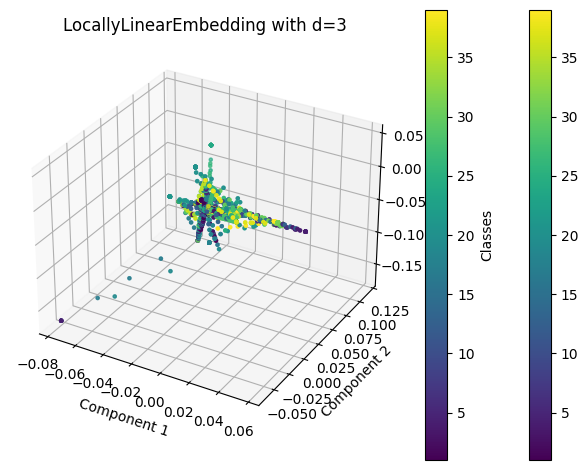

In [41]:
reduce_and_plot(LocallyLinearEmbedding, data, labels)

#### 2.

In [42]:
def compute_npr(original_data, reduced_data, k=10):
    nbrs_orig = NearestNeighbors(n_neighbors=k).fit(original_data)
    nbrs_red = NearestNeighbors(n_neighbors=k).fit(reduced_data)
    _, indices_orig = nbrs_orig.kneighbors(original_data)
    _, indices_red = nbrs_red.kneighbors(reduced_data)
    preservation_count = sum([len(set(indices_orig[i]).intersection(indices_red[i])) for i in range(len(original_data))])
    return preservation_count / (len(original_data) * k)

reduced_data_2d = TSNE(n_components=2).fit_transform(data)
reduced_data_3d = TSNE(n_components=3).fit_transform(data)
reduced_data_1d = TSNE(n_components=int(mom_single_dimension)).fit_transform(data)

npr_2d = compute_npr(data, reduced_data_2d)
npr_3d = compute_npr(data, reduced_data_3d)
npr_intrinsic = compute_npr(data, reduced_data_1d)
print(f"NPR for d=2: {npr_2d}")
print(f"NPR for d=3: {npr_3d}")
print(f"NPR for intrinsic dimension: {npr_intrinsic}")

NPR for d=2: 0.6111745513866231
NPR for d=3: 0.7073409461663948
NPR for intrinsic dimension: 0.44143556280587276





1.  **NPR for  d=2**

    With a 2D embedding, 61.1\% of the local neighborhood relationships are     preserved. A bit incomplete capture.

2.   **NPR for  d=3**

    70.7\% seems a bit better

3. **NPR for  d=1**

    And for 1D embedding we see a significant decrease

#### 4.

In [45]:
!pip install gudhi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.5 MB/s eta 0:00:00


In [50]:
import gudhi as gd

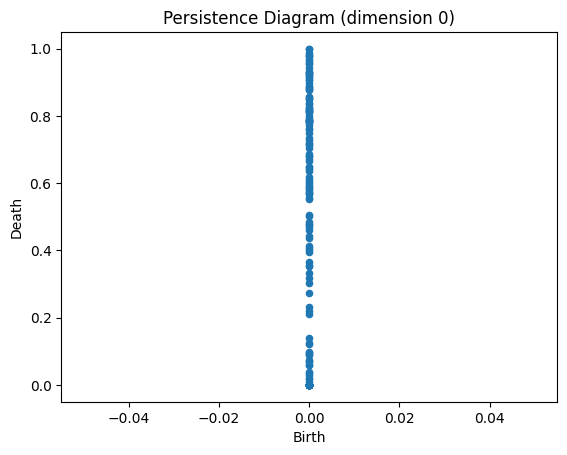

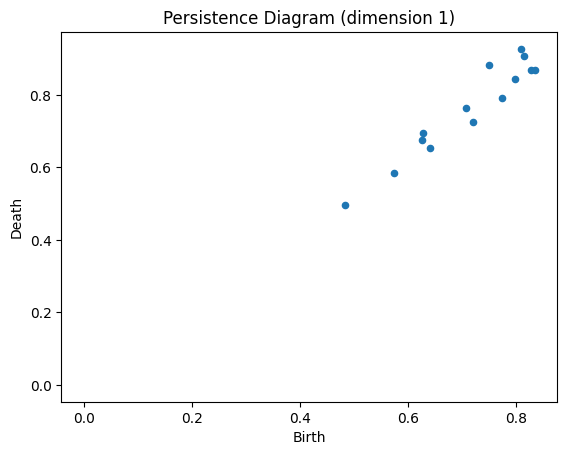

In [51]:
pca = PCA(n_components=29)
X_reduced = pca.fit_transform(data)

rips_complex = gd.RipsComplex(points=X_reduced, max_edge_length=1.0)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
simplex_tree.compute_persistence()
diag = simplex_tree.persistence_intervals_in_dimension(0)
diag1 = simplex_tree.persistence_intervals_in_dimension(1)

def plot_persistence_diagram(diag, dimension):
    plt.figure()
    plt.scatter(diag[:, 0], diag[:, 1], s=20)
    plt.plot([0, max(diag[:, 1])], [0, max(diag[:, 1])], 'k--')
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.title(f'Persistence Diagram (dimension {dimension})')
    plt.show()

plot_persistence_diagram(np.array(diag), 0)
plot_persistence_diagram(np.array(diag1), 1)

#### Grading:

- 8/10 points are awarded for completing all the tasks and giving proper answers to questions.
- 2/10 points are awarded for the quality of reporting, be sure to give explanations and comments to your solutions.
- +1 extra point may be awarded for the extra work performed, be creative.